In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fsps
%matplotlib inline

alldata = np.genfromtxt('ps5.data', usecols = range(15))
np.shape(alldata)
gdata = np.empty([463, 10])
gdata[:,0] = alldata[:,1]*3600+alldata[:,2]*60+alldata[:,3]
gdata[:,1] = (np.abs(alldata[:,4])*3600+alldata[:,5]*60+alldata[:,6])*np.sign(alldata[:,4])
gdata[:,2:] = alldata[:,7:]
gdata

array([[  2.25000000e+01,   1.42184000e+05,   8.20000000e+00, ...,
          9.99900000e+01,   9.99900000e+01,   9.99900000e+01],
       [  1.18100000e+02,  -5.56590000e+04,   9.20000000e-01, ...,
          5.00000000e-02,   1.23500000e+01,   3.00000000e-02],
       [  3.31800000e+02,  -1.01153000e+05,   1.04000000e+01, ...,
          5.00000000e-02,   1.58200000e+01,   4.00000000e-02],
       ..., 
       [  5.00735000e+04,   1.52750000e+04,   2.59000000e+00, ...,
          1.20000000e-01,   1.85400000e+01,   1.10000000e-01],
       [  5.84279000e+04,   1.95736000e+05,   1.93000000e+00, ...,
          9.99900000e+01,   1.91100000e+01,   6.00000000e-02],
       [  8.55340000e+04,   1.39384000e+05,   2.54000000e+00, ...,
          6.00000000e-02,   1.70000000e+01,   4.00000000e-02]])

In [3]:
metallicity = 6.27 - .11*(gdata[:,3]-5*(np.log10(gdata[:,2]*1e5)))

fuv_sfr = []
fuv_err = []
M_B = []
masses = []
for i in range(len(gdata[:,-4])):
    if (gdata[i,-4] == 99.99) | (gdata[i,-3] == 99.99) :
        pass
    else:
        absmag = np.log10(gdata[i,-4])-5*(np.log10(gdata[i,2]*1e6)-1) # absolute magnitude
        F_nuv = 10**(-.4*(absmag+48.6))
        L_nuv = 4*np.pi*(10*3.08e18)**2* F_nuv
        powL_nuv = L_nuv*(3e18/1528.) 
        fuv_sfr1 = -np.log10(powL_nuv) + 43.35
        err = np.log10(gdata[i,-4]+gdata[i,-3])-5*(np.log10(gdata[i,2]*1e6)-1)
        F_nuverr = 10**(-.4*(err+48.6))
        L_nuverr = 4*np.pi*(10*3.08e18)**2* F_nuverr
        powL_nuverr = L_nuverr*(3e18/1528.) 
        fuv_err1 = -np.log10(powL_nuverr) + 43.35- fuv_sfr1
        fuv_sfr.append(fuv_sfr1)
        fuv_err.append(gdata[i,-3])
        M_now = gdata[i,3]-5*(np.log10(gdata[i,2]*1e6)-1)
        M_B.append(M_now)
        mass = (13.3-M_now)/2.5
        masses.append(mass)

fuv_sfr = np.asarray(fuv_sfr)
fuv_err = np.asarray(fuv_err)
M_B = np.asarray(M_B)
masses = np.asarray(masses)
print(max(M_B), min(M_B))

-6.71624645199 -20.8624147428


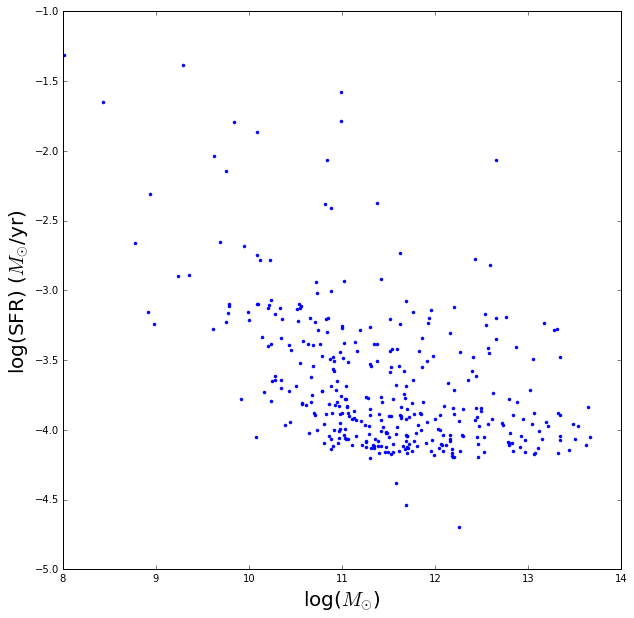

In [6]:
plt.figure(figsize=(10,10))
plt.plot(masses, fuv_sfr, '.')
plt.xlabel('log($M_{\odot}$)', fontsize = 20)
plt.ylabel('log(SFR) ($M_{\odot}$/yr)', fontsize = 20)

In [9]:
fuv_err

array([ 0.00069459,  0.00054406,  0.00050869,  0.00061755,  0.00069073,
        0.00085198,  0.0006478 ,  0.00049676,  0.00062116,  0.00058954,
        0.00052372,  0.00076226,  0.00077657,  0.00051594,  0.00084865,
        0.00099448,  0.00075893,  0.00054067,  0.00052215,  0.00053174,
        0.00052152,  0.0005559 ,  0.00108236,  0.00063193,  0.00074589,
        0.00101032,  0.00095479,  0.00063656,  0.00064507,  0.00065728,
        0.00103644,  0.00213415,  0.00062242,  0.0009542 ,  0.00087131,
        0.00139361,  0.0022446 ,  0.00086212,  0.00071695,  0.00091941,
        0.00092526,  0.00070761,  0.00106191,  0.00125759,  0.00059269,
        0.00063378,  0.00063331,  0.00062919,  0.00123839,  0.00069907,
        0.00121652,  0.00130738,  0.00058432,  0.00199497,  0.00065348,
        0.0006034 ,  0.00264292,  0.00068348,  0.00066052,  0.00064651,
        0.00064499,  0.00057465,  0.00064893,  0.00057238,  0.00064603,
        0.00055061,  0.00058471,  0.00073661,  0.00061668,  0.00

In [10]:
import emcee

def lnprob(theta, x, y, err):
    model = theta[0]+ x*theta[1]
    val = -.5*np.sum((y-model)**2/err**2)
    return val

ndim, nwalkers = 2, 100
pos = [1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = [masses, fuv_sfr, fuv_err])
sampler.run_mcmc(pos, 1000)

(array([[-0.75797784, -0.25782682],
        [-0.46220606, -0.2845871 ],
        [-0.29264934, -0.29696682],
        [-0.83739361, -0.25205635],
        [-0.76176406, -0.24762994],
        [-0.15112009, -0.30735065],
        [-0.7885288 , -0.24830819],
        [-0.13302075, -0.30599178],
        [ 0.59309834, -0.36931083],
        [-1.27683771, -0.20907879],
        [-0.58213578, -0.26611517],
        [-0.47964983, -0.27414456],
        [-0.33055484, -0.28838158],
        [-1.18465029, -0.21487375],
        [-0.84403766, -0.24627105],
        [-0.56499017, -0.26205889],
        [-1.06968362, -0.22721128],
        [-0.75867409, -0.25023335],
        [-0.05407466, -0.31497071],
        [-2.35694128, -0.10864969],
        [-0.95219259, -0.238931  ],
        [-1.64844431, -0.17704975],
        [-0.56291641, -0.27260982],
        [-0.75216359, -0.25113468],
        [ 0.18859952, -0.3388099 ],
        [-0.25387356, -0.29658074],
        [-1.3758705 , -0.20051604],
        [ 0.06881031, -0.324

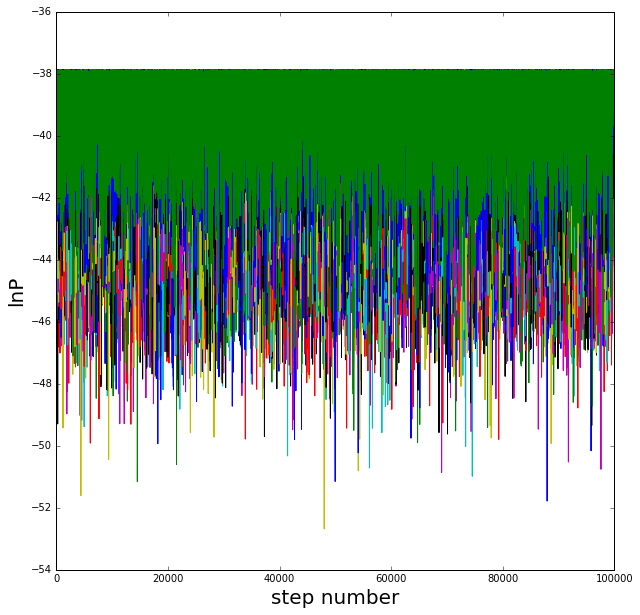

In [11]:
plt.figure(figsize = (10,10))
[plt.plot(sampler.lnprobability[i,250:]) for i in range(100)]
plt.xlabel('step number', fontsize = 20)
plt.ylabel('lnP', fontsize = 20)

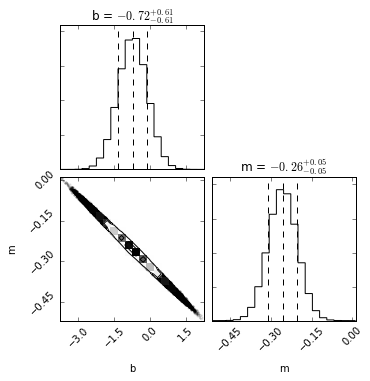

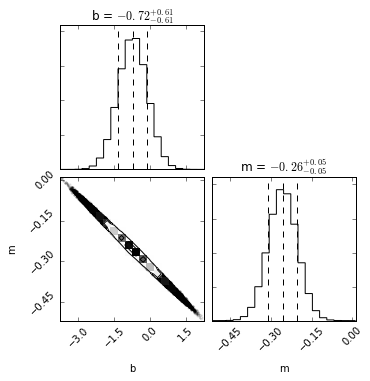

In [12]:
import corner

samples = sampler.chain[:,250:, :].reshape((-1, ndim))
corner.corner(samples, labels=['b', 'm'], fontsize = 20, show_titles = True, quantiles=[0.16, 0.5, 0.84])

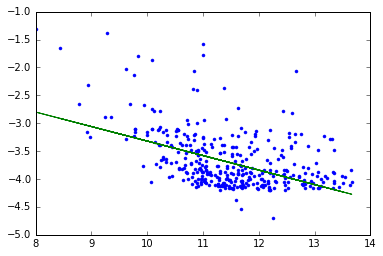

In [13]:
plt.plot(masses, fuv_sfr, '.')
plt.plot(masses, -.26*masses-.72)